In [28]:
# importing relevent library and dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, recall_score,precision_score, classification_report,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier

data = pd.read_csv (r'/Users/prashntshukla/Desktop/DS_MiniProject_ANON.csv')
print (data)


         DATE_FOR RTD_ST_CD CustomerSegment     Tenure        Age MART_STATUS  \
0       5/19/2014     ST_S0               1  16.175222  78.403833       MS_S0   
1       5/17/2014     ST_S0               1  15.931554  70.989733       MS_S1   
2       5/15/2014     ST_S0               1  15.937029  87.578371       MS_S2   
3       5/16/2014     ST_S1               1  15.934292  68.438056       MS_S2   
4       5/20/2014     ST_S0               1  15.501711  80.514716       MS_S0   
...           ...       ...             ...        ...        ...         ...   
130081  5/17/2014    ST_S16            NONE   0.131417  46.258727       MS_S2   
130082  5/19/2014    ST_S41            NONE   0.117728  36.574949       MS_S1   
130083  5/16/2014    ST_S14            NONE   0.131417  56.906229       MS_S3   
130084  5/15/2014    ST_S14            NONE   0.087611  23.857632       MS_S2   
130085  5/19/2014     ST_S9               3   9.434634  32.276523       MS_S1   

       GENDER  CHANNEL1_6M 

In [3]:
# Analyzing the datasets
print("The data set has rows {} and columns {}".format(data.shape[0],data.shape[1]))
print(data.dtypes)
print(data.isnull().sum())
for col in data:
    print(data[col].unique(),col,"\n")



The data set has rows 130086 and columns 29
DATE_FOR                  object
RTD_ST_CD                 object
CustomerSegment           object
Tenure                   float64
Age                      float64
MART_STATUS               object
GENDER                    object
CHANNEL1_6M              float64
CHANNEL2_6M              float64
CHANNEL3_6M              float64
CHANNEL4_6M              float64
CHANNEL5_6M              float64
METHOD1_6M               float64
RECENT_PAYMENT           float64
PAYMENTS_6M              float64
CHANNEL1_3M                int64
CHANNEL2_3M                int64
CHANNEL3_3M                int64
CHANNEL4_3M                int64
CHANNEL5_3M                int64
METHOD1_3M                 int64
PAYMENTS_3M                int64
NOT_DI_3M                  int64
NOT_DI_6M                  int64
EVENT1_30_FLAG             int64
EVENT2_90_SUM              int64
LOGINS                     int64
POLICYPURCHASECHANNEL      int64
Call_Flag                  int64

In [4]:
# Changing columns datatype to category
cols = ['Call_Flag', 'POLICYPURCHASECHANNEL', 'NOT_DI_6M', 'NOT_DI_3M','RECENT_PAYMENT','GENDER']
data[cols] = data[cols].astype('category')
print(data.dtypes)

DATE_FOR                   object
RTD_ST_CD                  object
CustomerSegment            object
Tenure                    float64
Age                       float64
MART_STATUS                object
GENDER                   category
CHANNEL1_6M               float64
CHANNEL2_6M               float64
CHANNEL3_6M               float64
CHANNEL4_6M               float64
CHANNEL5_6M               float64
METHOD1_6M                float64
RECENT_PAYMENT           category
PAYMENTS_6M               float64
CHANNEL1_3M                 int64
CHANNEL2_3M                 int64
CHANNEL3_3M                 int64
CHANNEL4_3M                 int64
CHANNEL5_3M                 int64
METHOD1_3M                  int64
PAYMENTS_3M                 int64
NOT_DI_3M                category
NOT_DI_6M                category
EVENT1_30_FLAG              int64
EVENT2_90_SUM               int64
LOGINS                      int64
POLICYPURCHASECHANNEL    category
Call_Flag                category
dtype: object


In [5]:
# As column "EVENT1_30_FLAG" has only one unique value I will remove that column as it will not impact the data

data = data.drop(["EVENT1_30_FLAG","DATE_FOR"], axis=1)
# As missing datapoints are around 0.6%, so we can directly drop those rows. Also, I found that the missing values are in the same row. 
# So, only 809 rows were dropped
# We can also use missing value imputation method like knn imputation, random forest to predict missing values
data=pd.DataFrame(data.dropna())
data.shape

(129277, 27)

In [6]:
# Seperating categorical and numerical dataset
numeric_data = pd.DataFrame(data.select_dtypes(include=[np.number]))
categorical_data = pd.DataFrame(data.select_dtypes(exclude=[np.number]))
print(numeric_data.shape)
print(categorical_data.shape)

(129277, 18)
(129277, 9)


In [7]:
numeric_data.corr(method='pearson', min_periods=1)


,Tenure,Age,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,CHANNEL5_6M,METHOD1_6M,PAYMENTS_6M,CHANNEL1_3M,CHANNEL2_3M,CHANNEL3_3M,CHANNEL4_3M,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,EVENT2_90_SUM,LOGINS
Tenure,1.000000,0.404367,-0.170688,0.064590,0.139932,-0.074824,0.104667,-0.251553,0.015312,-0.149676,0.049083,0.130135,-0.075787,0.095298,-0.243140,-0.015767,-0.063626,-0.098734
Age,0.404367,1.000000,-0.163336,0.079022,0.263810,0.011743,0.034998,-0.280082,-0.069889,-0.140079,0.067768,0.251791,0.002438,0.030896,-0.268419,-0.077235,-0.085963,-0.214799
CHANNEL1_6M,-0.170688,-0.163336,1.000000,-0.086003,-0.098335,0.041458,-0.075422,0.353334,0.278603,0.904554,-0.072783,-0.089943,0.060785,-0.068647,0.329450,0.240767,0.094677,0.079430
CHANNEL2_6M,0.064590,0.079022,-0.086003,1.000000,-0.188392,0.042378,-0.161057,0.158564,0.185772,-0.078562,0.949437,-0.182217,0.029161,-0.153988,0.157539,0.160611,0.040641,-0.190373
CHANNEL3_6M,0.139932,0.263810,-0.098335,-0.188392,1.000000,-0.123164,-0.148084,-0.285193,0.102407,-0.086446,-0.174720,0.964903,-0.107430,-0.140859,-0.266246,0.097728,-0.087691,-0.179692
CHANNEL4_6M,-0.074824,0.011743,0.041458,0.042378,-0.123164,1.000000,-0.111875,0.219733,0.146282,0.027828,0.050986,-0.117888,0.876719,-0.106143,0.211452,0.126596,0.184425,-0.087292
CHANNEL5_6M,0.104667,0.034998,-0.075422,-0.161057,-0.148084,-0.111875,1.000000,-0.220227,0.135583,-0.066334,-0.152373,-0.142800,-0.098227,0.965934,-0.206910,0.113604,-0.060226,-0.048883
METHOD1_6M,-0.251553,-0.280082,0.353334,0.158564,-0.285193,0.219733,-0.220227,1.000000,0.396520,0.293969,0.162749,-0.272431,0.193813,-0.209483,0.943047,0.339036,0.161220,0.170460
PAYMENTS_6M,0.015312,-0.069889,0.278603,0.185772,0.102407,0.146282,0.135583,0.396520,1.000000,0.227268,0.191462,0.104870,0.130325,0.140468,0.382355,0.863580,0.155181,0.134903
CHANNEL1_3M,-0.149676,-0.140079,0.904554,-0.078562,-0.086446,0.027828,-0.066334,0.293969,0.227268,1.000000,-0.069116,-0.080660,0.036840,-0.062010,0.323598,0.255618,0.040860,0.063604


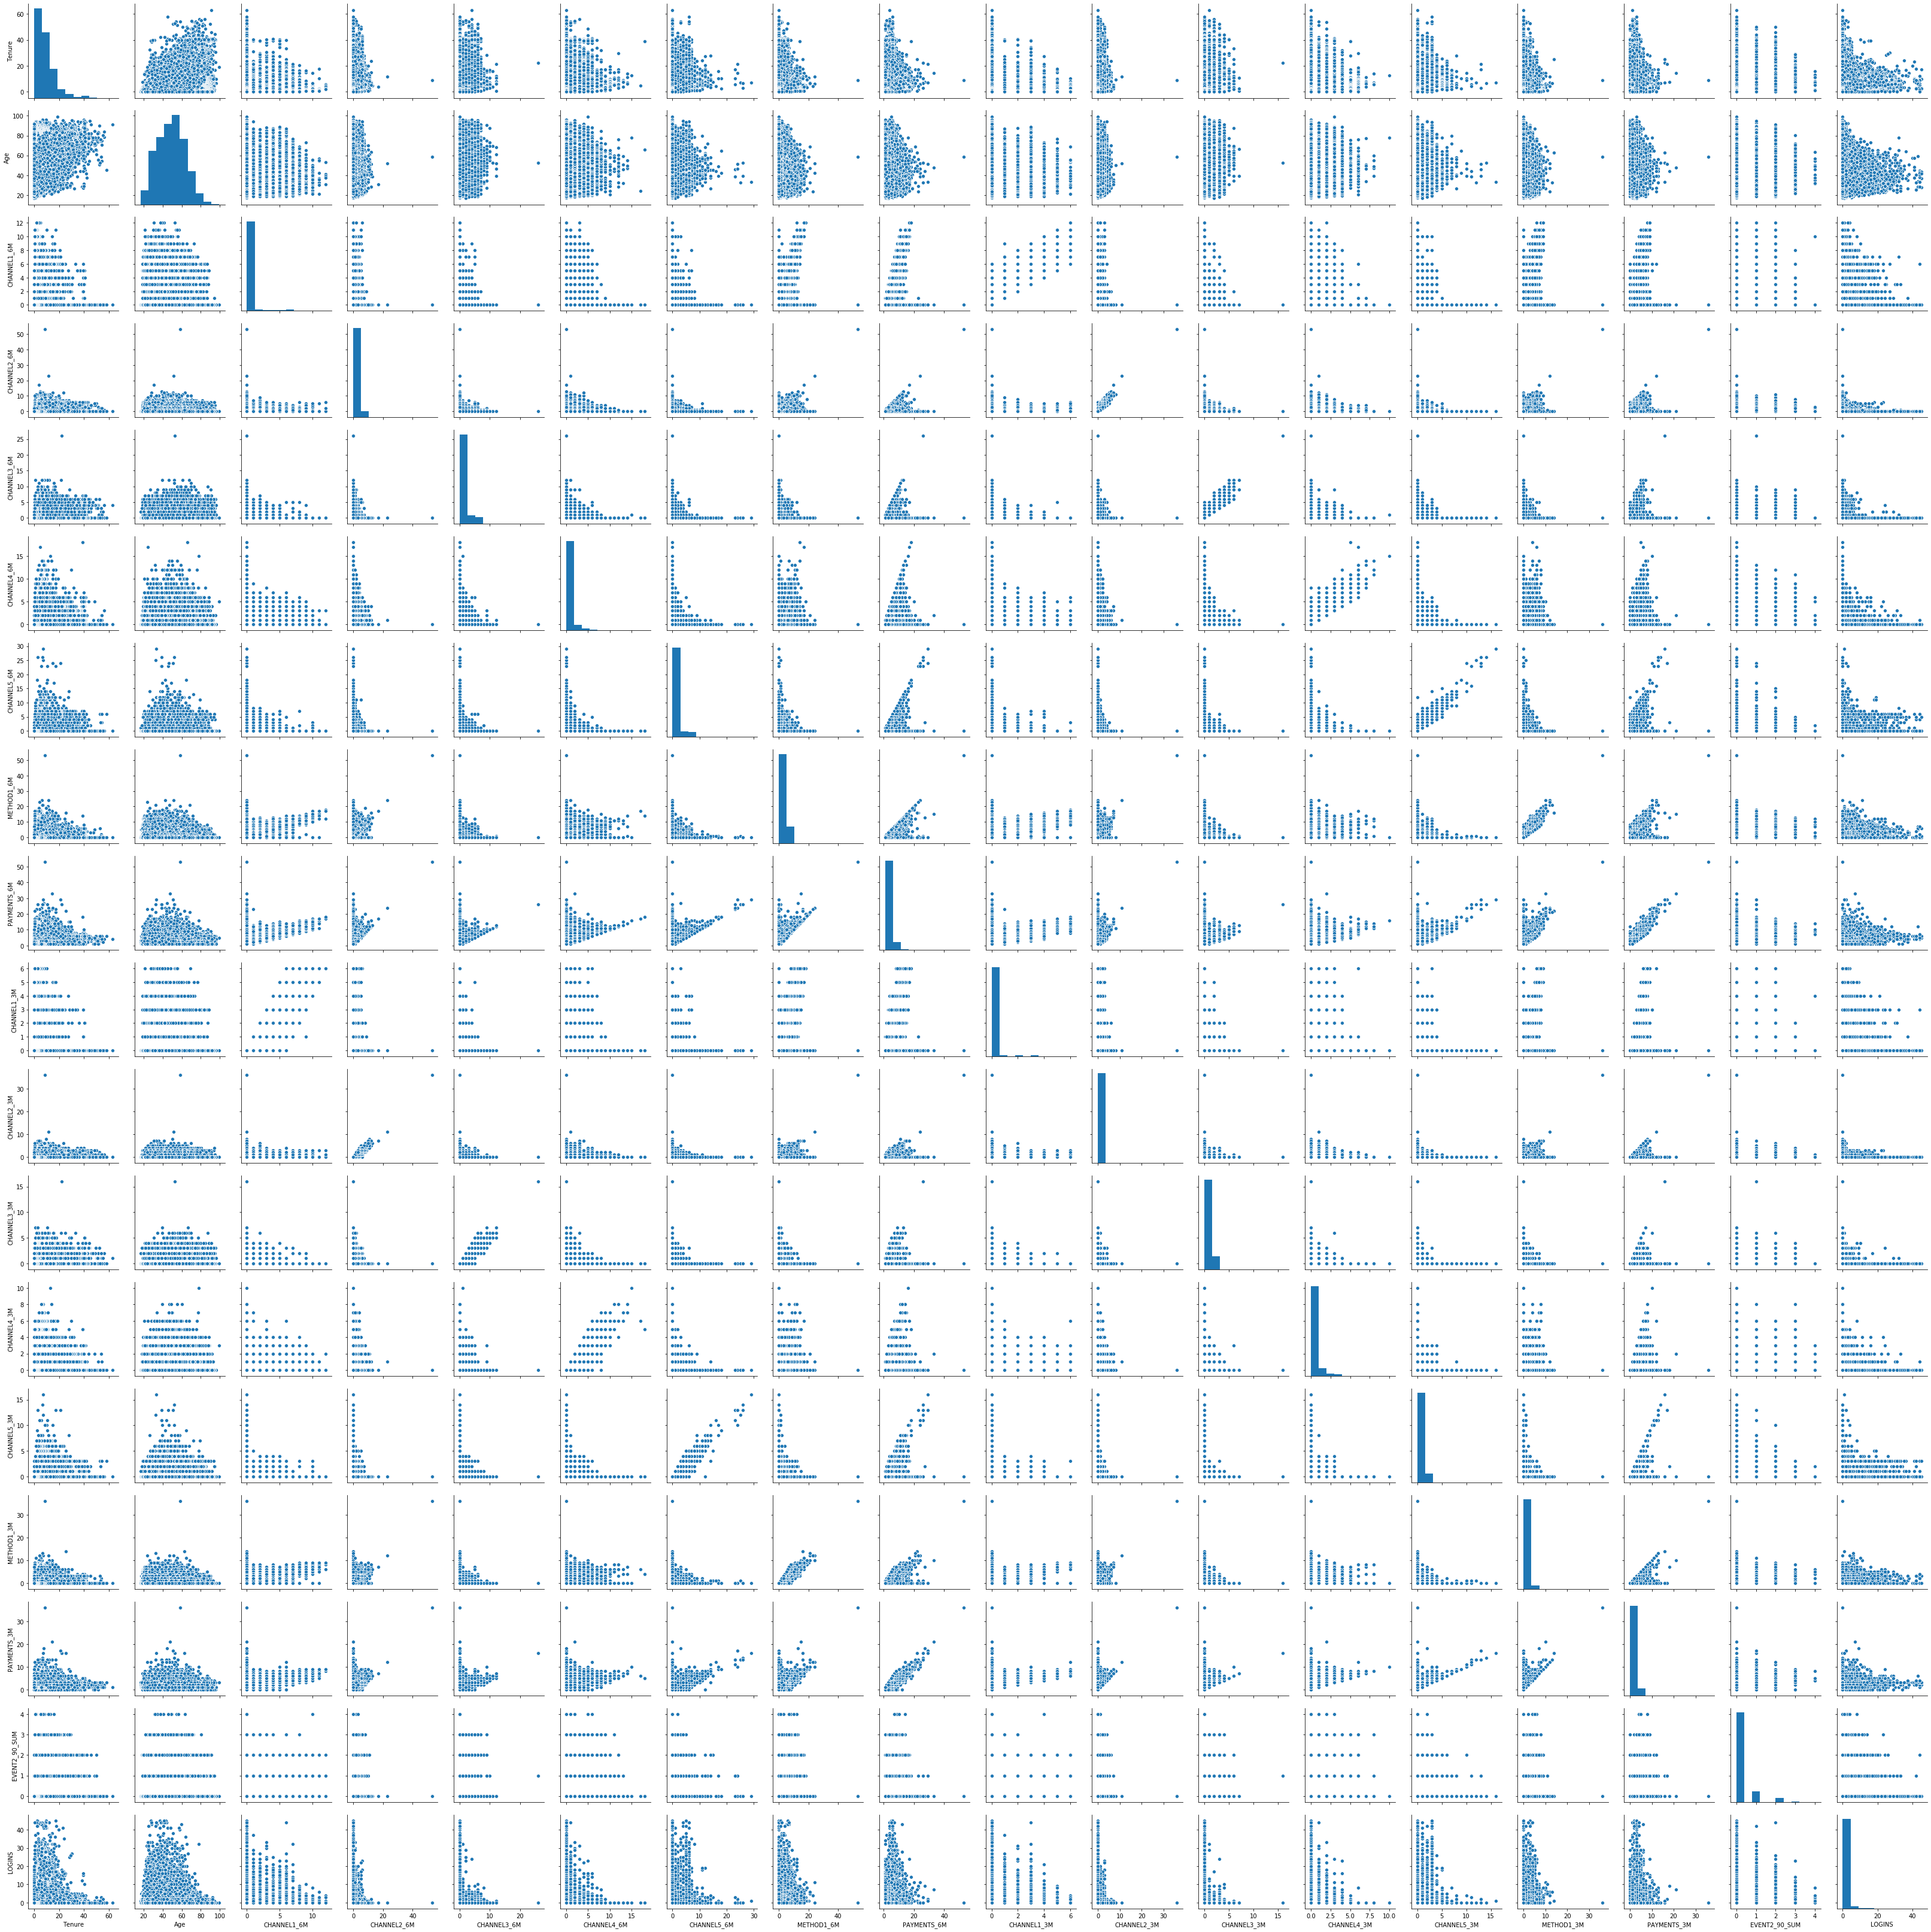

In [7]:
sns.pairplot(numeric_data)

In [8]:
# From the above data we can see that all channels in 6 month are highly correlated with the corresponding channel
# Hence I have decided to drop the columns with 3 months data to avoid multicollinearity

numeric_data=numeric_data.drop(["CHANNEL1_3M","CHANNEL2_3M","CHANNEL3_3M","CHANNEL4_3M","CHANNEL5_3M","METHOD1_3M","PAYMENTS_3M"],axis=1)


In [9]:
# checking Correlation among integer features
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif['variable'] = numeric_data.columns
print(vif)


         VIF       variable
0   3.006823         Tenure
1   6.596107            Age
2   1.330206    CHANNEL1_6M
3   1.730112    CHANNEL2_6M
4   1.899786    CHANNEL3_6M
5   1.327010    CHANNEL4_6M
6   1.589945    CHANNEL5_6M
7   2.636622     METHOD1_6M
8   9.687087    PAYMENTS_6M
9   1.227890  EVENT2_90_SUM
10  1.475633         LOGINS


In [10]:
# From the result, we can see that data contains lots of outliers.
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1
print(((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).sum())
print(numeric_data.describe())

Tenure            5179
Age                111
CHANNEL1_6M       9182
CHANNEL2_6M      22071
CHANNEL3_6M      26405
CHANNEL4_6M      26016
CHANNEL5_6M      17205
METHOD1_6M         545
PAYMENTS_6M       1617
EVENT2_90_SUM    18758
LOGINS           13355
dtype: int64
              Tenure            Age    CHANNEL1_6M    CHANNEL2_6M  \
count  129277.000000  129277.000000  129277.000000  129277.000000   
mean        8.591581      48.813929       0.261810       0.948467   
std         7.297798      14.037131       1.092346       1.880123   
min         0.032854      16.689938       0.000000       0.000000   
25%         3.252567      37.845311       0.000000       0.000000   
50%         7.006160      49.111567       0.000000       0.000000   
75%        11.630390      58.830938       0.000000       1.000000   
max        63.091034      99.348392      12.000000      53.000000   

         CHANNEL3_6M    CHANNEL4_6M    CHANNEL5_6M     METHOD1_6M  \
count  129277.000000  129277.000000  129277

Tenure           1.665721
Age              0.125897
CHANNEL1_6M      4.699654
CHANNEL2_6M      2.305201
CHANNEL3_6M      2.133464
CHANNEL4_6M      3.979972
CHANNEL5_6M      3.055250
METHOD1_6M       1.385923
PAYMENTS_6M      0.448869
EVENT2_90_SUM    2.770884
LOGINS           7.186274
dtype: float64


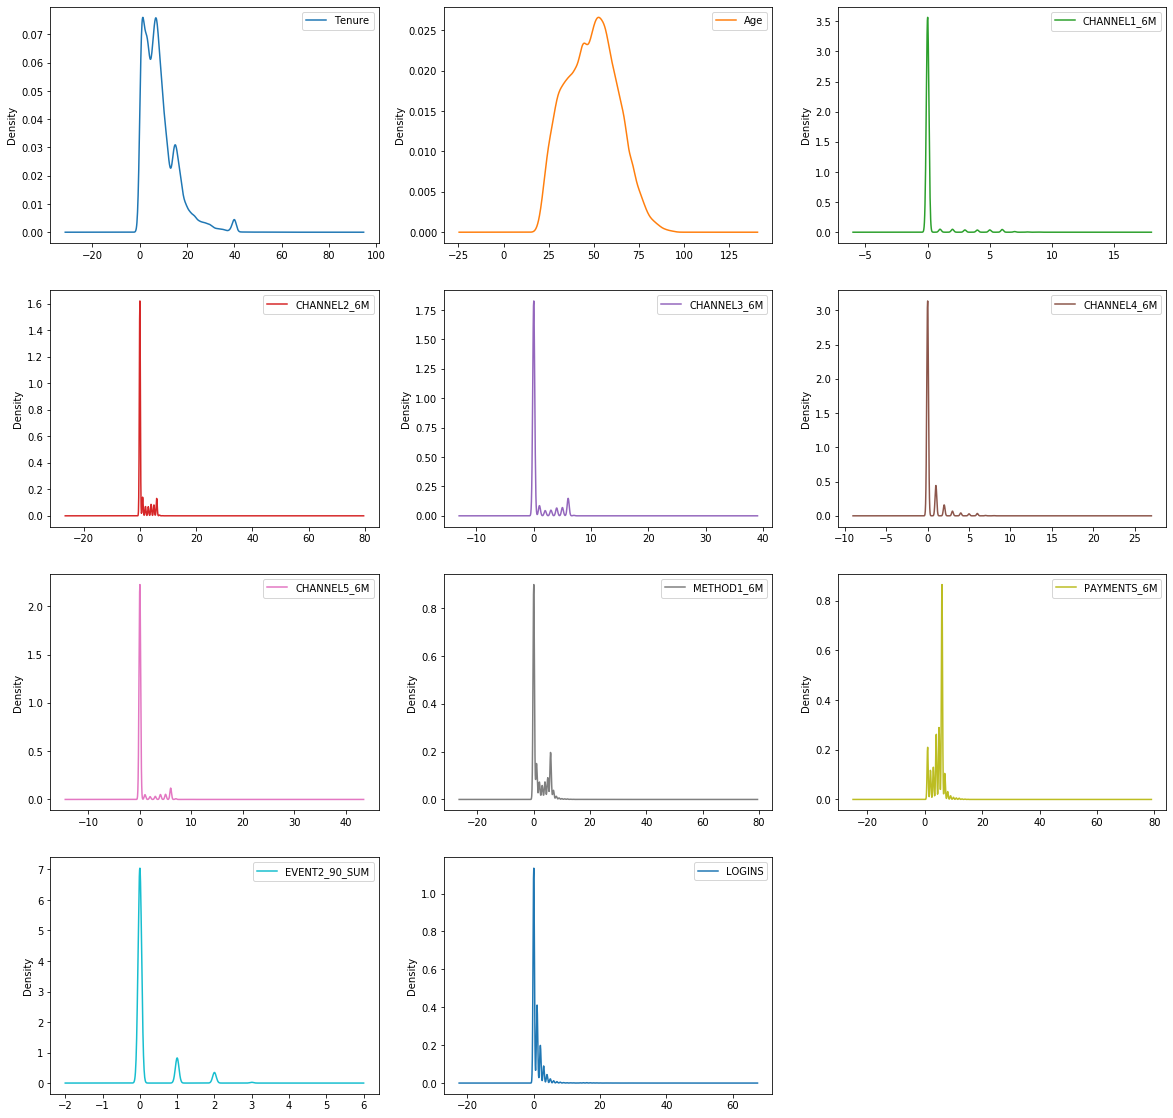

In [11]:
# Our data is skewed
print(numeric_data.skew())

numeric_data.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize = (20, 20))
plt.show()

Tenure          -0.356624
Age             -0.467153
CHANNEL1_6M      3.861418
CHANNEL2_6M      1.444257
CHANNEL3_6M      1.782646
CHANNEL4_6M      2.260325
CHANNEL5_6M      2.458592
METHOD1_6M       0.658969
PAYMENTS_6M     -1.191212
EVENT2_90_SUM    2.324482
LOGINS           1.364407
dtype: float64


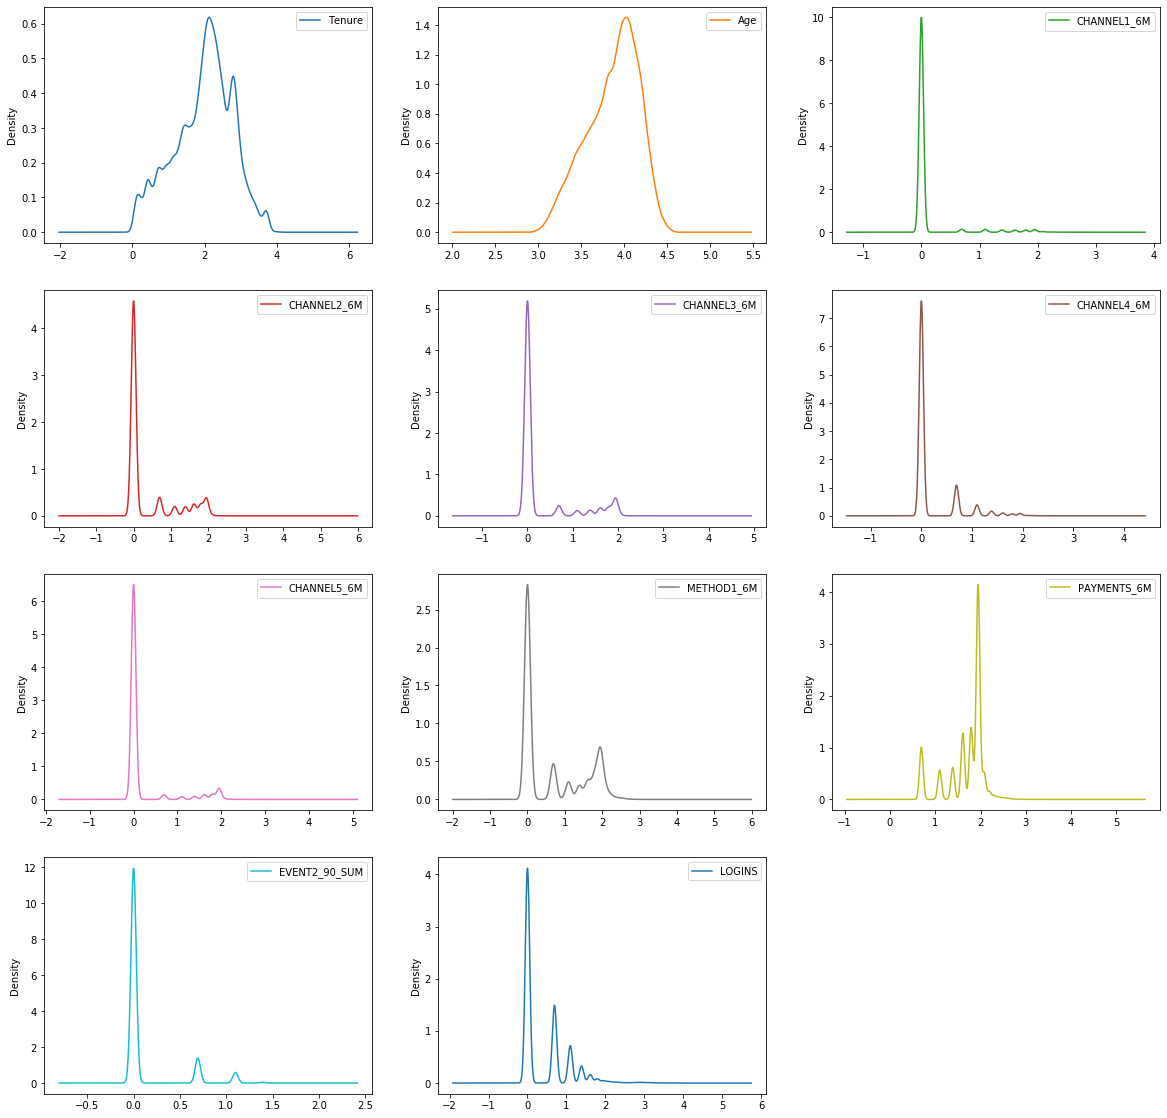

In [11]:
#Applying log(x+1) transformation to reduce skewness

numeric_data=numeric_data.applymap(lambda x: np.log(x+1))
print(numeric_data.skew())
numeric_data.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize = (20, 20))
plt.show()


In [12]:
#Analyzing the target variable
# From the outpue I can see that our dataset is imbalanced as 96.4% is "0" and 3.6% is "1"
categorical_data.Call_Flag.value_counts()
categorical_data.shape

(129277, 9)

In [13]:
final_data = pd.concat([numeric_data, categorical_data], axis=1)
final_data

,Tenure,Age,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,CHANNEL5_6M,METHOD1_6M,PAYMENTS_6M,EVENT2_90_SUM,LOGINS,RTD_ST_CD,CustomerSegment,MART_STATUS,GENDER,RECENT_PAYMENT,NOT_DI_3M,NOT_DI_6M,POLICYPURCHASECHANNEL,Call_Flag
0,2.843468,4.374547,0.0,0.000000,0.693147,0.0,1.791759,0.000000,1.945910,0.0,0.0,ST_S0,1,MS_S0,F,0.0,0,0,0,0
1,2.829179,4.276524,0.0,1.945910,0.000000,0.0,0.000000,1.945910,1.945910,0.0,0.0,ST_S0,1,MS_S1,F,0.0,0,0,0,0
2,2.829502,4.483888,0.0,0.000000,2.397895,0.0,0.000000,0.000000,2.397895,0.0,0.0,ST_S0,1,MS_S2,M,0.0,0,0,0,0
3,2.829341,4.240435,0.0,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.0,0.0,ST_S1,1,MS_S2,M,0.0,0,0,1,0
4,2.803464,4.400784,0.0,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.0,0.0,ST_S0,1,MS_S0,F,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130081,0.123471,3.855637,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.693147,0.0,0.0,ST_S16,NONE,MS_S2,M,0.0,0,0,0,0
130082,0.111298,3.626338,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.098612,0.0,0.0,ST_S41,NONE,MS_S1,M,0.0,0,0,0,0
130083,0.123471,4.058825,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.693147,0.0,0.0,ST_S14,NONE,MS_S3,M,1.0,0,0,0,0
130084,0.083984,3.213165,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.693147,0.0,0.0,ST_S14,NONE,MS_S2,M,1.0,0,0,0,0


In [14]:
# Encoding the categorical colum. Column "RTD_ST_CD" has 50 categories.
# so I am using Target encoding with smooth mean
#from category_encoders import LeaveOneOutEncoder
def smooth_mean(df, hg, on, m):
    mean = df[on].mean()
    
    agg = df.groupby(hg)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    smooth = (counts * means + m * mean) / (counts + m)    
    return df[hg].map(smooth)


In [15]:

final_data['Call_Flag'] = final_data['Call_Flag'].astype('int')


final_data['RTD_ST_CD'] = smooth_mean(final_data, hg='RTD_ST_CD', on='Call_Flag', m=10)
final_data['MART_STATUS'] = smooth_mean(final_data, hg='MART_STATUS', on='Call_Flag', m=10)
final_data['CustomerSegment'] = smooth_mean(final_data, hg='CustomerSegment', on='Call_Flag', m=10)

In [16]:
print(final_data['MART_STATUS'])
print(final_data['CustomerSegment'])

0         0.047724
1         0.039180
2         0.031725
3         0.031725
4         0.047724
            ...   
130081    0.031725
130082    0.039180
130083    0.039997
130084    0.031725
130085    0.039180
Name: MART_STATUS, Length: 129277, dtype: float64
0         0.033488
1         0.033488
2         0.033488
3         0.033488
4         0.033488
            ...   
130081    0.027177
130082    0.027177
130083    0.027177
130084    0.027177
130085    0.049387
Name: CustomerSegment, Length: 129277, dtype: float64


In [17]:
#One hot encoding 

enc1= pd.get_dummies(final_data['GENDER'], prefix='GENDER')
enc2= pd.get_dummies(final_data['RECENT_PAYMENT'], prefix='RECENT_PAYMENT')
enc3= pd.get_dummies(final_data['NOT_DI_3M'], prefix='NOT_DI_3M')
enc4= pd.get_dummies(final_data['NOT_DI_6M'], prefix='NOT_DI_6M')
enc5= pd.get_dummies(final_data['POLICYPURCHASECHANNEL'], prefix='POLICYPURCHASECHANNEL')
final_data = pd.concat([final_data, enc1, enc2, enc3, enc4, enc5], axis=1)

final_data = final_data.drop(["GENDER","RECENT_PAYMENT","NOT_DI_3M","NOT_DI_6M","POLICYPURCHASECHANNEL"], axis=1)


In [18]:
final_data['Call_Flag'] = final_data['Call_Flag'].astype('int')
final_data.dtypes

Tenure                     float64
Age                        float64
CHANNEL1_6M                float64
CHANNEL2_6M                float64
CHANNEL3_6M                float64
CHANNEL4_6M                float64
CHANNEL5_6M                float64
METHOD1_6M                 float64
PAYMENTS_6M                float64
EVENT2_90_SUM              float64
LOGINS                     float64
RTD_ST_CD                  float64
CustomerSegment            float64
MART_STATUS                float64
Call_Flag                    int64
GENDER_F                     uint8
GENDER_M                     uint8
RECENT_PAYMENT_0.0           uint8
RECENT_PAYMENT_1.0           uint8
NOT_DI_3M_0                  uint8
NOT_DI_3M_1                  uint8
NOT_DI_6M_0                  uint8
NOT_DI_6M_1                  uint8
POLICYPURCHASECHANNEL_0      uint8
POLICYPURCHASECHANNEL_1      uint8
dtype: object

In [20]:
# Splitting the data 
indep_cols = final_data.drop("Call_Flag", axis=1)
dep_cols = final_data["Call_Flag"]
print(indep_cols.shape)
print(dep_cols.shape)

(129277, 24)
(129277,)


0    124552
1      4725
Name: Call_Flag, dtype: int64


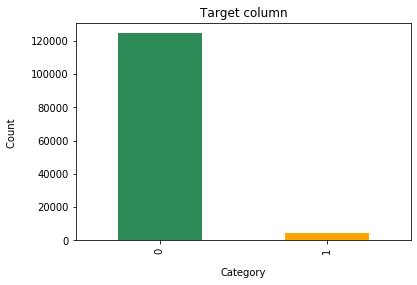

In [21]:
# Analyzing the target column
print(final_data['Call_Flag'].value_counts())
final_data['Call_Flag'].value_counts().plot(kind='bar', color=['seagreen','orange'])
plt.xlabel("Category", labelpad=14)
plt.ylabel("Count ", labelpad=14)
plt.title("Target column")

plt.show()


In [23]:
# Performing the StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
sts = StratifiedShuffleSplit(n_splits=4, test_size=0.3,
                             random_state=0)
sts.get_n_splits(indep_cols, dep_cols)


4

In [29]:
# Applying Random Forest
seed=45

score = make_scorer(roc_auc_score)
hypamts = {'n_estimators':(10,15,20),
              'criterion':('gini','entropy'),
              'min_samples_split':(2,3,4),
              'min_samples_leaf':(1,2,3)}

for train_index, test_index in sts.split(indep_cols, dep_cols):
    X_train, X_test = np.array(indep_cols)[train_index,:], np.array(indep_cols)[test_index,:]
    y_train, y_test = np.array(dep_cols)[train_index], np.array(dep_cols)[test_index]
    
    random = RandomForestClassifier(random_state=seed, warm_start=False, class_weight='balanced')
    grid_sh = GridSearchCV(random, param_grid=hypamts, scoring=score, verbose=1, n_jobs=4, cv=4)
    grid_sh = grid_sh.fit(X_train, y_train.ravel())
    
    random = grid_sh.best_estimator_
    y_pred_test = random.predict(X_test)
    y_pred_train=random.predict(X_train)
    #print("F1 score is:", f1_score(y_test, y_pred_test))
    print("Precision for test:",precision_score(y_test, y_pred_test))
    print("precision for train:",precision_score(y_train, y_pred_train) )
    print("Recall for test:", recall_score(y_test, y_pred_test)) 
    print("Recall for train :", recall_score(y_train, y_pred_train)) 
    print("AUC score of test:", roc_auc_score(y_test, y_pred_test))
    print("AUC score of train:",roc_auc_score(y_train, y_pred_train))


    

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.2857981220657277
precision for train: 0.6060424169667867
Recall for test: 0.343441466854725
Recall for train : 0.915935893559117
AUC score of test: 0.655435875535161
AUC score of train: 0.9466759962370402
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.27711496746203906
precision for train: 0.558986087287974
Recall for test: 0.3603667136812412
Recall for train : 0.8869065618385243
AUC score of test: 0.6623462857064345
AUC score of train: 0.9301828017138852
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.2777454968041836
precision for train: 0.5982421875
Recall for test: 0.33709449929478136
Recall for train : 0.9262171152101603
AUC score of test: 0.6519144818906064
AUC score of train: 0.9513119388818907
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.28188319427890346
precision for train: 0.6037735

In [34]:
print(classification_report(y_test, random.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     37366
           1       0.28      0.33      0.31      1418

    accuracy                           0.94     38784
   macro avg       0.63      0.65      0.64     38784
weighted avg       0.95      0.94      0.95     38784



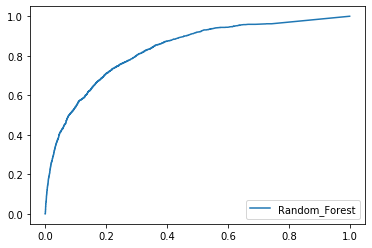

In [38]:

y_pred = random.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="Random_Forest")
plt.legend(loc=4)
plt.show()

In [33]:
# Applying Logistic Regression
hypamts = {'solver':('liblinear','newton-cg','sag')}

for train_index, test_index in sts.split(indep_cols, dep_cols):
    X_train, X_test = np.array(indep_cols)[train_index,:], np.array(indep_cols)[test_index,:]
    y_train, y_test = np.array(dep_cols)[train_index], np.array(dep_cols)[test_index]

    logist = LogisticRegressionCV(Cs=10, cv=4, scoring=score, penalty='l2', random_state=seed, class_weight='balanced',max_iter=200)
    grid_sh = GridSearchCV(logist, param_grid=hypamts, scoring=score, verbose=1, n_jobs=4, cv=4)
    grid_sh = grid_sh.fit(X_train, y_train.ravel())
    logist = grid_sh.best_estimator_
    y_pred_test = logist.predict(X_test)
    y_pred_train=logist.predict(X_train)
    #print("F1 score is:", f1_score(y_test, y_pred_test))
    print("Precision for test:",precision_score(y_test, y_pred_test))
    print("precision for train:",precision_score(y_train, y_pred_train) )
    print("Recall for test:", recall_score(y_test, y_pred_test)) 
    print("Recall for train :", recall_score(y_train, y_pred_train)) 
    print("AUC score of test:", roc_auc_score(y_test, y_pred_test))
    print("AUC score of train:",roc_auc_score(y_train, y_pred_train))
    print(confusion_matrix(y_test, logist.predict(X_test)))



Fitting 4 folds for each of 3 candidates, totalling 12 fits
Precision for test: 0.1144879267277269
precision for train: 0.11732851985559567
Recall for test: 0.7757404795486601
Recall for train : 0.7862110674327185
AUC score of test: 0.7740234271639357
AUC score of train: 0.7809315608308042
[[28858  8508]
 [  318  1100]]
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  Conve

Precision for test: 0.11567700842408055
precision for train: 0.11506556061011507
Recall for test: 0.7940761636107193
Recall for train : 0.7801632899909283
AUC score of test: 0.7818531543311852
AUC score of train: 0.7762904399854856
[[28758  8608]
 [  292  1126]]
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  Conve

Precision for test: 0.11637059887246037
precision for train: 0.11790174095342267
Recall for test: 0.771509167842031
Recall for train : 0.7822800120955549
AUC score of test: 0.7745973821868187
AUC score of train: 0.7801416806285588
[[29059  8307]
 [  324  1094]]
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/prashntshukla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  Conve

Precision for test: 0.11591641542779915
precision for train: 0.11565415346158997
Recall for test: 0.7863187588152327
Recall for train : 0.7834895675839129
AUC score of test: 0.7793660913917732
AUC score of train: 0.7781256247526611
[[28862  8504]
 [  303  1115]]


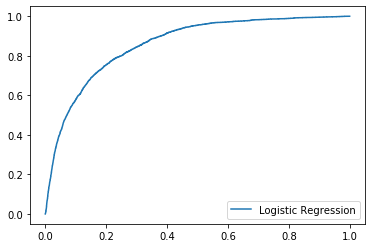

In [40]:
y_pred = logist.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred)
auc = metrics.roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="Logistic Regression")
plt.legend(loc=4)
plt.show()

In [41]:
print(classification_report(y_test, logist.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     37366
           1       0.12      0.79      0.20      1418

    accuracy                           0.77     38784
   macro avg       0.55      0.78      0.53     38784
weighted avg       0.96      0.77      0.84     38784



In [42]:
# Applying Gradient Boosting 
hypamts = {'loss':('deviance','exponential'),
              'learning_rate':(0.01,0.1,1.0),
              'min_samples_split':(2,3,4),
              'min_samples_leaf':(1,2,3)}
for train_index, test_index in sts.split(indep_cols, dep_cols):
    X_train, X_test = np.array(indep_cols)[train_index,:], np.array(indep_cols)[test_index,:]
    y_train, y_test = np.array(dep_cols)[train_index], np.array(dep_cols)[test_index]

    grad = GradientBoostingClassifier(random_state=seed, warm_start=False)
    grid_sh = GridSearchCV(grad, param_grid=hypamts, scoring=score, verbose=1, n_jobs=4, cv=4)
    grid_obj = grid_sh.fit(X_train, y_train.ravel())
    grad = grid_sh.best_estimator_
    y_pred_test = grad.predict(X_test)
    y_pred_train=grad.predict(X_train)
    #print("F1 score is:", f1_score(y_test, y_pred_test))
    print("Precision for test:",precision_score(y_test, y_pred_test))
    print("precision for train:",precision_score(y_train, y_pred_train) )
    print("Recall for test:", recall_score(y_test, y_pred_test)) 
    print("Recall for train :", recall_score(y_train, y_pred_train)) 
    print("AUC score of test:", roc_auc_score(y_test, y_pred_test))
    print("AUC score of train:",roc_auc_score(y_train, y_pred_train))
    print(confusion_matrix(y_test, grad.predict(X_test)))


Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.4194915254237288
precision for train: 0.6014109347442681
Recall for test: 0.06981664315937941
Recall for train : 0.10311460538252193
AUC score of test: 0.5330751042163112
AUC score of train: 0.5502612230454463
[[37229   137]
 [ 1319    99]]
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.39823008849557523
precision for train: 0.5549872122762148
Recall for test: 0.09520451339915374
Recall for train : 0.1312367704868461
AUC score of test: 0.5448725023774659
AUC score of train: 0.5636226519834959
[[37162   204]
 [ 1283   135]]
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Precision for test: 0.37209302325581395
precision for train: 0.5760598503740648
Recall for test: 0.09026798307475317
Recall for train : 0.13970365890535227
AUC score of test: 0.542243663431612
AUC score of train: 0.5679019751182647
[[37150   216]
 [ 1290   128]]
Fitting 4 folds for each 

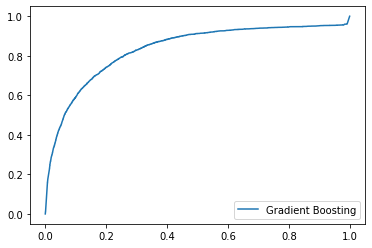

In [43]:
y_pred = grad.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred)
auc = metrics.roc_auc_score(y_train, y_pred)
plt.plot(fpr,tpr,label="Gradient Boosting")
plt.legend(loc=4)
plt.show()

In [44]:
"""
# Model Selection:
# From the above results, we can see that Random forest is overfitted. 
#Similarly, Gradient boosting algorithm has huge difference between recall of true and false classes (same for f1 score) which is due to imbalance data.
# Logistic Regression is performing better than others with AUC score around 0.77 for training dataset and 0.78 for test dataset. 
# So we can say that Logistic Regression is best model for this dataset.
"""

'\n# Model Selection:\n# From the above results, we can see that Random forest is overfitted. \n#Similarly, Gradient boosting algorithm has huge difference between recall of true and false classes (same for f1 score) which is due to imbalance data.\n# Logistic Regression is performing better than others with AUC score around 0.77 for training dataset and 0.78 for test dataset. \n# So we can say that Logistic Regression is best model for this dataset.\n'

In [47]:
print(classification_report(y_test, grad.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37366
           1       0.26      0.01      0.02      1418

    accuracy                           0.96     38784
   macro avg       0.61      0.50      0.50     38784
weighted avg       0.94      0.96      0.95     38784

